In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from itertools import combinations



%matplotlib inline
base_fldr='/data/tbaharav/umi_dylan/'
analysis_fldr=base_fldr+'umi_analysis/'
fpath = analysis_fldr + 'ensembl2symbol.pkl'

with open(fpath, 'rb') as f:
    map_e2s = pickle.load(f)
    map_s2e = pickle.load(f)

save_dir = base_fldr+'/figs'


In [ ]:

def compute_pairwise_hamming_distances(umi_list, hamming_threshold=1):
    """
    Given a list of UMI strings, compute the fraction of all unique pairs that are Hamming distance 1 apart.
    """

    def hamming(s1, s2):
        return sum(c1 != c2 for c1, c2 in zip(s1, s2))

    n = len(umi_list)
    if n < 2:
        return 0.0

    pairs = list(combinations(umi_list, 2))
    num_pairs = len(pairs)
    num_hamming1 = sum(1 for u1, u2 in pairs if hamming(u1, u2) <= hamming_threshold)
    return num_hamming1 / num_pairs



In [ ]:


########### Monte Carlo simulation to estimate the distribution of the fraction of UMI pairs with Hamming distance 1
def monte_carlo_hamming_estimator(umi_prob_df, n_umis_true, n_simulations=20, rand_seed=0):
    """
    Monte Carlo simulation to estimate the distribution of the fraction of UMI pairs with Hamming distance 1.

    Parameters:
    umi_prob_arr (numpy.ndarray): Array of UMI probabilities.
    n_umis_true (int): Number of UMIs to sample.
    n_simulations (int): Number of Monte Carlo simulations.

    Returns:
    list: List of Hamming-1 fractions from each simulation.
    """
    np.random.seed(rand_seed)
    umi_seqs = umi_prob_df['umi'].values
    umi_prob_arr = umi_prob_df['prob'].values
    umi_prob_arr = np.array(umi_prob_arr, dtype=float)
    umi_prob_arr /= umi_prob_arr.sum()  # Normalize probabilities
    K = len(umi_prob_arr)
    assert len(umi_prob_arr) == K, "Length of umi_prob_arr must match number of UMIs"
    assert n_umis_true <= K, "Cannot sample more UMIs than available (without replacement)"

    stats = []
    for _ in tqdm(range(n_simulations), desc="Monte Carlo Hamming Estimator"):
        sampled_idx = np.random.choice(K, size=n_umis_true, replace=False, p=umi_prob_arr)
        sampled_umis = umi_seqs[sampled_idx]
        stat = compute_pairwise_hamming_distances(sampled_umis)
        stats.append(stat)
    return stats

In [ ]:
cleaned_tsv = pd.read_csv(analysis_fldr + '/cleaned_umis_UR_1k.tsv', sep='\t')
umi_probs_12 = pd.read_csv(analysis_fldr + '/umi_counts_1k_overall.tsv', sep='\t', header=None)
umi_probs_12.columns = ['umi', 'prob']

In [ ]:
per_gene_counts = cleaned_tsv.drop(columns='UR').groupby('GX').size().reset_index(name='total_count').sort_values(by='total_count', ascending=False)
per_gene_counts['GN'] = per_gene_counts['GX'].map(map_e2s)

per_cell_counts = cleaned_tsv.groupby('CB').size().reset_index(name='total_count').sort_values(by='total_count', ascending=False)


In [ ]:
###### compute pairwise hamming distances for UB and UR counts
num_top_genes = 5
num_top_cells = 5
top_genes = per_gene_counts.head(num_top_genes)['GX'].values
top_cells = per_cell_counts.head(num_top_cells)['CB'].values

results = []

for gene in tqdm(top_genes, desc="Genes"):
    for cell in tqdm(top_cells, desc="Cells", leave=False):
        ub = cleaned_tsv[(cleaned_tsv['GX'] == gene) & (cleaned_tsv['CB'] == cell)].UB.unique()
        ur = cleaned_tsv[(cleaned_tsv['GX'] == gene) & (cleaned_tsv['CB'] == cell)].UR.unique()
        ub_list = list(ub)
        ur_list = list(ur)
        ub_frac = compute_pairwise_hamming_distances(ub_list)
        ur_frac = compute_pairwise_hamming_distances(ur_list)
        results.append({
            'gene': gene,
            'cell': cell,
            'ub_hamming_fraction': ub_frac,
            'ur_hamming_fraction': ur_frac,
            'num_ub': len(ub_list),
            'num_ur': len(ur_list)
        })

hamming_df = pd.DataFrame(results)

Genes: 100%|██████████| 5/5 [01:31<00:00, 18.29s/it]


In [31]:
###### generate for num top genes * num top cells a corresponding number of null samples
n_to_use = hamming_df.num_ub.mean().astype(int)
null_results = monte_carlo_hamming_estimator(umi_probs_12, n_umis_true=n_to_use, n_simulations=num_top_cells * num_top_genes)

Monte Carlo Hamming Estimator: 100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


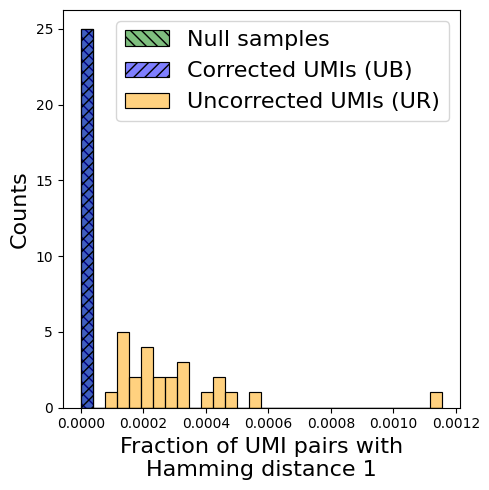

In [32]:
############# Figure generation for paper: fig:ur_vs_ub_1
plt.figure(figsize=(5,5))
# Compute common bin edges for both distributions
all_values = np.concatenate([hamming_df['ub_hamming_fraction'].values, hamming_df['ur_hamming_fraction'].values])
bins = np.histogram_bin_edges(all_values, bins=30)

sns.histplot(null_results, label='Null samples', bins=bins, color='green', alpha=0.5, hatch='\\\\\\')
sns.histplot(data=hamming_df, x='ub_hamming_fraction', label='Corrected UMIs (UB)', bins=bins, color='blue', alpha=0.5, hatch='///')
sns.histplot(data=hamming_df, x='ur_hamming_fraction', label='Uncorrected UMIs (UR)', bins=bins, color='orange', alpha=0.5)
plt.legend(fontsize=16)
plt.xlabel(f'Fraction of UMI pairs with\nHamming distance 1', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.tight_layout()
# plt.savefig(save_dir+'/umi_hamming_overall.pdf', bbox_inches='tight')

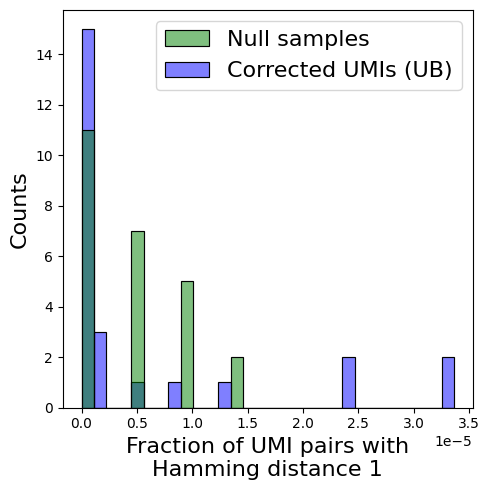

In [ ]:
############# Figure generation for paper: fig:ur_vs_ub_2

plt.figure(figsize=(5,5))
# Compute common bin edges for both distributions
all_values = np.concatenate([hamming_df['ub_hamming_fraction'].values, null_results])
bins = np.histogram_bin_edges(all_values, bins=30)
sns.histplot(null_results, label='Null samples', bins=bins, color='green', alpha=0.5, zorder=2)
sns.histplot(data=hamming_df, x='ub_hamming_fraction', label='Corrected UMIs (UB)', bins=bins, color='blue', alpha=0.5)
plt.legend(fontsize=16)
plt.xlabel('Fraction of UMI pairs with\nHamming distance 1', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.tight_layout()
# plt.savefig(save_dir+'/umi_hamming_UB_null.pdf', bbox_inches='tight')